In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read in Data Set

In [344]:
raw_data = pd.read_csv('household_power_consumption.txt', sep=';', na_values='?', index_col=0,
                       parse_dates=[[0,1]], infer_datetime_format=True, dayfirst=True)

In [345]:
for i in range(raw_data.shape[1]):
    bad_cnt = raw_data.iloc[:, i].isnull().sum()
    print('Column %d has %d bad values.' % (i, bad_cnt))

Column 0 has 25979 bad values.
Column 1 has 25979 bad values.
Column 2 has 25979 bad values.
Column 3 has 25979 bad values.
Column 4 has 25979 bad values.
Column 5 has 25979 bad values.
Column 6 has 25979 bad values.


In [346]:
print(raw_data.shape)
# print(raw_data.iloc[4,[2,3,6,7,8]])
# print(raw_data.head)

(2075259, 7)


### Fill missing data with average curve
This method of filling the data will replace each missing value with the average of the last good value and the next good value. If there are multiple missing values, the last good value will be updated as each value is filled in. For example, if the series of data is [0, ?, ?, 4], the filled in set will be [0, 2, 3, 4].  
I think this is a reasonable way to fill in power data since power is continuous and can't change value instantaneously. It might be problematic for the regions where there are many values (multiple days worth) missing, though.

In [347]:
def FillAverageCurve(raw_data, full_row_outage=True, method='curve'):

    filled_data = raw_data.copy()
    if (full_row_outage):
        max_range = 1
    else:
        max_range = filled_data.shape[1]
    
    for col in range(max_range):
        last_row = -2

        null_series = filled_data.iloc[:, col].isnull()
        null_indices = np.where(null_series.values == True)[0].tolist()
        skip_cnt = 0
        for i in range(len(null_indices)):
            row = null_indices[i]

            if (last_row == row - 1):
                new_val = (last_good + next_good) / 2
                filled_data.iloc[row] = new_val
                if (method == 'curve'):
                    last_good = new_val
                continue

            if (i == len(null_indices) - 1):
                # This is the last null value in the column. The next row is good.
                filled_data.iloc[row] = (filled_data.iloc[row - 1] + filled_data.iloc[row + 1]) / 2
            else:
                good_idx = 0
                for k in range(i, len(null_indices)):
                    if (null_indices[k] != null_indices[k + 1] - 1):
                        good_idx = k
                        break
                    elif (k == len(null_indices) - 1):
                        good_idx = k
                next_good = filled_data.iloc[null_indices[good_idx] + 1]
                last_good = filled_data.iloc[row - 1]
                new_val = (last_good + next_good) / 2
                filled_data.iloc[row] = new_val
                if (method == 'curve'):
                    last_good = new_val
                last_row = row

        print('Column %d cleaned' % col)
    return filled_data

In [348]:
filled_data = FillAverageCurve(raw_data)#, method='flat')

Column 0 cleaned


In [349]:
# Check a few missing value locations to verify the fill worked correctly
print(raw_data.iloc[6838])
print(filled_data.iloc[6839])
print(filled_data.iloc[6840])
print(raw_data.iloc[6841])

Global_active_power        0.244
Global_reactive_power      0.000
Voltage                  242.290
Global_intensity           1.000
Sub_metering_1             0.000
Sub_metering_2             0.000
Sub_metering_3             0.000
Name: 2006-12-21 11:22:00, dtype: float64
Global_active_power        0.245
Global_reactive_power      0.000
Voltage                  242.015
Global_intensity           1.000
Sub_metering_1             0.000
Sub_metering_2             0.000
Sub_metering_3             0.000
Name: 2006-12-21 11:23:00, dtype: float64
Global_active_power        0.2455
Global_reactive_power      0.0000
Voltage                  241.8775
Global_intensity           1.0000
Sub_metering_1             0.0000
Sub_metering_2             0.0000
Sub_metering_3             0.0000
Name: 2006-12-21 11:24:00, dtype: float64
Global_active_power        0.246
Global_reactive_power      0.000
Voltage                  241.740
Global_intensity           1.000
Sub_metering_1             0.000
Sub_meter

### Add a new column for apparent power
If I remember my power systems courses correctly, the power utility needs to consider apparent power, which is a combination of both active and reactive power. This next bit of code will calculate the apparent power and add it as a new column. This column will be useful if we want to do analysis related to how much power the utility needs to generate.

In [350]:
# Add apparent power column
filled_data['Global_apparent_power'] = np.sqrt(filled_data['Global_active_power']**2 +
                                              filled_data['Global_reactive_power']**2)

### Aggregate data by hour/day/month/season rather than by minute

In [351]:
hourly_data = filled_data.resample('H').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean})

daily_data = filled_data.resample('D').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean})

monthly_data = filled_data.resample('MS').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean})

season_data = filled_data.resample('QS-JUL').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean})

# print(season_data)

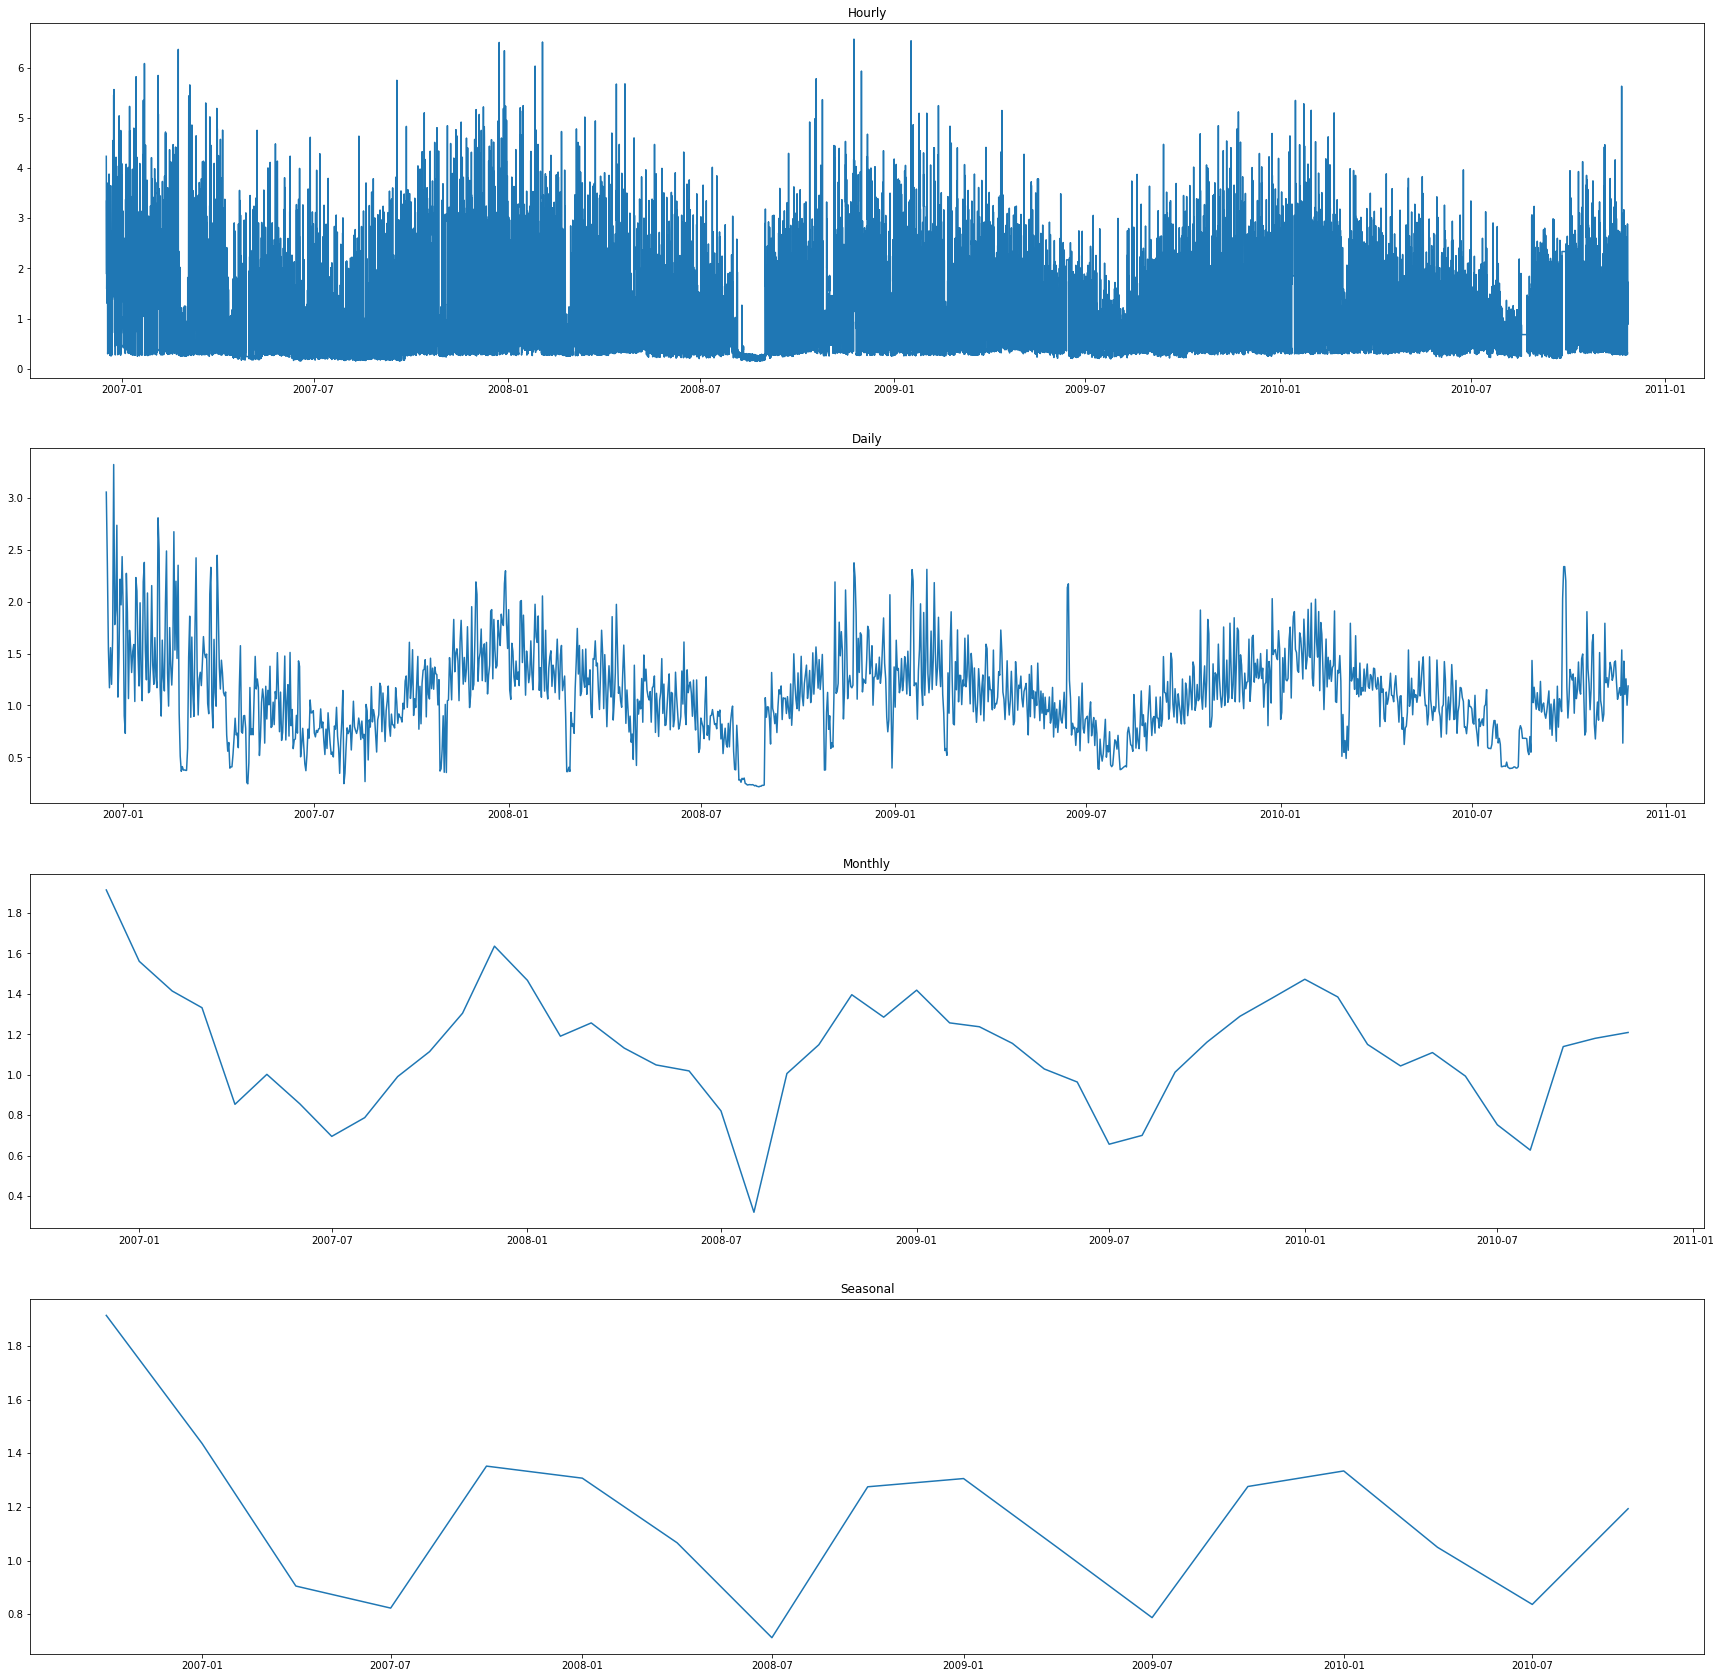

In [352]:
plt.figure(figsize=[30,30])
ax = plt.subplot(4, 1, 1)
plt.plot(hourly_data['Global_apparent_power'])
plt.title('Hourly')
ax = plt.subplot(4, 1, 2)
plt.plot(daily_data['Global_apparent_power'])
plt.title('Daily')
ax = plt.subplot(4, 1, 3)
plt.plot(monthly_data['Global_apparent_power'])
plt.title('Monthly')
ax = plt.subplot(4, 1, 4)
plt.plot(season_data['Global_apparent_power'])
plt.title('Seasonal')
plt.show()